In [1]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.utils.data import Dataset

import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
import itertools

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features), 
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()
        
        channels = input_shape[0]
        
        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features
        
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]
            
        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            
        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]
        
        # Unpacking
        self.model = nn.Sequential(*model) 
        
    def forward(self, x):
        return self.model(x)

In [3]:
# data (path)
root = 'josef/'
# 3, 300, 450
# data (img)
img_width = 256
img_height = 256
channels = 3

# number of cpu threads to use during batch generation
n_cpu = 2

# training
epoch = 0 # epoch to start training from
n_epochs = 200 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 100 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

In [4]:
transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

In [5]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

In [6]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/munch_jpg')+'/*.*')[0:475])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[0:475])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/munch_jpg')+'/*.*')[0:475])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[0:475])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])
        
        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)
            
        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}
    
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [7]:
val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=1,
    shuffle=True
    # num_workers=n_cpu
)

# Testing

In [ ]:
img = next(iter(val_dataloader))

In [ ]:
# T = transforms.Compose(transforms_)
# image = Image.open('josef/photo_jpg/merged_0_1.jpg')
# image = to_rgb(image)
# item = T(image)

real_img = img['B']
fake_img = BA(real_img).detach()
recon_img = AB(fake_img).detach()

fig = plt.figure(figsize=(1,3))
fig.add_subplot(1,3,1)
plt.imshow(real_img.squeeze().numpy())
fig.add_subplot(1,3,2)
plt.imshow(fake_img)
fig.add_subplot(1,3,3)
plt.imshow(recon_img)
plt.show()

# real_img = make_grid(real_img, nrow=1, normalize=True)
# fake_img = make_grid(fake_img, nrow=1, normalize=True)
# recon_img = make_grid(recon_img, nrow=1, normalize=True)

# grid = torch.cat((real_img, fake_img, recon_img), 1)
# plt.imshow(grid.cpu().permute(1,2,0))
# plt.axis('off')
# plt.show()

In [ ]:
test = F.normalize(fake_img) 

In [ ]:
test.shape

In [ ]:
np.max(test.numpy())

In [ ]:
test = (test + 1) / 2.0

In [ ]:
test = test * 256

In [ ]:
test = test.squeeze()

In [ ]:
img = test.numpy()

In [ ]:
img = img.astype(np.uint8)

In [ ]:
Image.fromarray(maybe, 'RGB')

In [ ]:
maybe = np.moveaxis(img, [0,1,2], [-1,-2,-3]).shape

In [ ]:
plt.imshow(maybe)
plt.show()

In [ ]:
np.max(test.numpy())

# Done Testing

In [8]:
Tensor = torch.Tensor

In [39]:
def Munchify():
    imgs = next(iter(val_dataloader))
    
    real_A = imgs['A'].type(Tensor) # B : photo
    fake_B = AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = BA(real_B).detach()
    
    real_A = make_grid(real_A, nrow=1, normalize=True)
    fake_B = make_grid(fake_B, nrow=1, normalize=True)
    real_B = make_grid(real_B, nrow=1, normalize=True)
    fake_A = make_grid(fake_A, nrow=1, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.axis('off')
    plt.show()

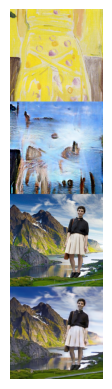

In [41]:
Munchify()

In [90]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

BA = GeneratorResNet(input_shape, n_residual_blocks)
AB = GeneratorResNet(input_shape, n_residual_blocks)

# optimizer = torch.optim.Adam(itertools.chain(AB.parameters(), BA.parameters()), lr=lr, betas=(b1,b2))

AB_checkpoint = torch.load('./gen_models/AB_epoch_196.pt')
BA_checkpoint = torch.load('./pytorch_models/v3/BA/Checkpoint_BA_epoch_40.pt')

In [91]:
AB.load_state_dict(AB_checkpoint['state_dict'])
BA.load_state_dict(BA_checkpoint['state_dict'])
# optimizer.load_state_dict(BA_checkpoint['optimizer_state_dict'])

<All keys matched successfully>

In [92]:
# optimizer.state_dict()

In [93]:
AB.eval()
BA.eval()

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [59]:
def generate_samples(model_architecture, input_shape, n_residual_blocks):
    
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    
    for i in range(200):
        
        # load new checkpoint
        model = model_architecture(input_shape, n_residual_blocks)
        model_checkpoint = torch.load(f'./pytorch_models/v3/BA/Checkpoint_BA_epoch_{i+1}.pt')
        model.load_state_dict(model_checkpoint['state_dict'])
        model.eval()

        # open and transform image to be syle transfered
        image = Image.open('josef/photo_jpg/merged_1_1.jpg')
        image = transform(image).unsqueeze(0)

        # use generator to perform style transfer
        image = model(image).detach()
        
        # get correct dimensions, to ndarray, as image, and save
        image = image.squeeze().numpy()
        image = ((image + 1) / 2) * 256
        image = image.astype(np.uint8).transpose(1,2,0)
        img = Image.fromarray(image, 'RGB')
        img.save(f'generated_images/epoch_{i+1}.jpg', 'JPEG')

In [60]:
generate_samples(GeneratorResNet, input_shape, n_residual_blocks)

In [94]:
image = Image.open('josef/photo_jpg/merged_1_1.jpg')

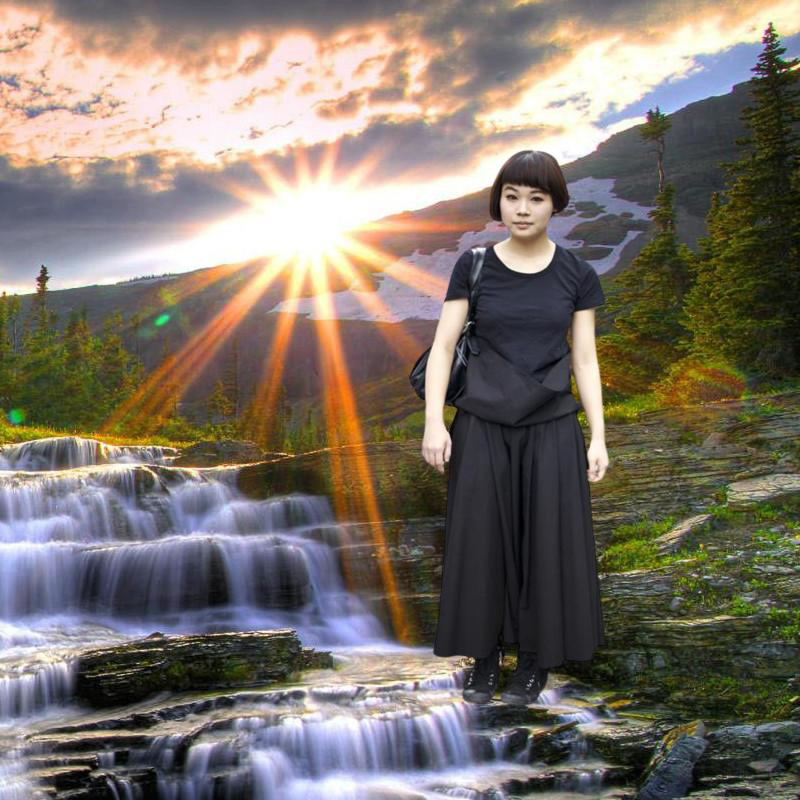

In [95]:
image

In [96]:


# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# transform = transforms.Compose(transforms_)

# image = transform(image)

# transform = transforms.Compose([
#     transforms.PILToTensor(),
#     transforms.ConvertImageDtype(torch.float),
# ])

In [97]:
image = transform(image).unsqueeze(0)

In [98]:
image.shape

torch.Size([1, 3, 800, 800])

In [99]:
image = BA(image).detach()

In [100]:
image.shape

torch.Size([1, 3, 800, 800])

In [101]:
image = image.squeeze().numpy()
image = ((image + 1) / 2) * 256
image = image.astype(np.uint8).transpose(1,2,0)
img = Image.fromarray(image, 'RGB')

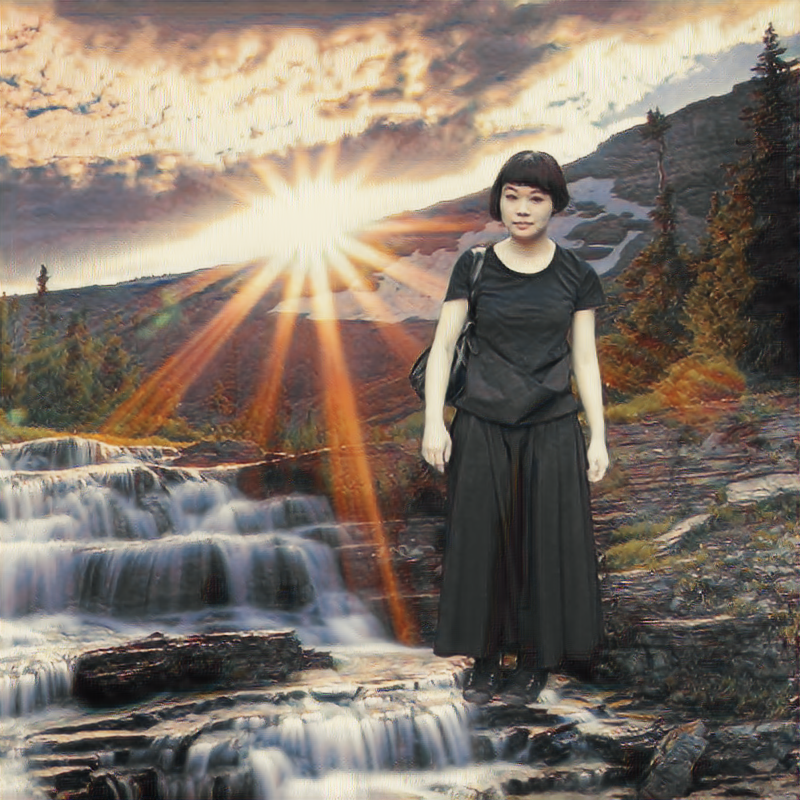

In [102]:
img

In [ ]:
def generate_samples(model, input_image):
    
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # open and transform image to be syle transfered
    image = input_image
    image = transform(image).unsqueeze(0)

    # use generator to perform style transfer
    image = model(image).detach()

    # get correct dimensions, to ndarray, as image, and save
    image = image.squeeze().numpy()
    image = ((image + 1) / 2) * 256
    image = image.astype(np.uint8).transpose(1,2,0)
    img = Image.fromarray(image, 'RGB')
    
    # create byte array, save image in byte array, convert to base64
    byte_arr = io.BytesIO()
    img.save(byte_arr, format='JPEG')
    byte_arr = byte_arr.getvalue()
    img_str = base64.b64encode(byte_arr).decode()
    
    return img_str

In [274]:
byte_arr = io.BytesIO()

In [275]:
img.save(byte_arr, format='JPEG')
byte_arr = byte_arr.getvalue()
img_str = base64.b64encode(byte_arr).decode()

In [276]:
img_str

'/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQgJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAMgAyADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDkUkBRvm7Dgj3pfNJX735VHAmd3J608IMd66ZU32M5VENErepp3mtnqaXyx70ohBPWp9m+xn7VCpK4Y4JNSx3UrkAetRrHtYEZqxbRws+D60cj7B7Q0z5yQA9aoXcspXdyCO1b1siGFVUcAd+agv7GMq7A8459qhqz1CVRmDF

In [273]:
import base64
import io

In [239]:
test = base64.b64encode(img)

TypeError: a bytes-like object is required, not 'Image'

In [233]:
with open('image_bytes.txt', 'wb') as byte_writer:
    byte_writer.write(test)

In [191]:
to_image = transforms.ToPILImage(mode='RGB')

In [143]:
img = to_image(image.squeeze())

In [171]:
img.getchannel

<bound method Image.getchannel of <PIL.Image.Image image mode=RGB size=1280x856 at 0x29BA9BBDF90>>

In [ ]:
image = make_grid(image, nrow=1, normalize=True)
grid = torch.cat((image,), 1)
plt.imshow(grid.cpu().permute(1,2,0))

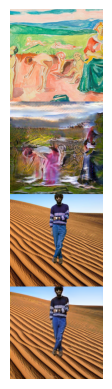

In [93]:
Munchify()

In [ ]:
test = image.squeeze(1)

In [ ]:
torch.squeeze(test, (0,1,2)).shape

In [ ]:
test = make_grid(image, nrow=1, normalize=True)
grid_t = torch.cat((image,), 1)
plt.imshow(grid_t.cpu().permute(1,2,0))

In [ ]:
test.unsqueeze(3).shape